**<h1>Análise de Sentimentos e Modelação de Tópicos de Tweets relacionados com a vacina Astrazeneca</h1>**

Trabalho realizado no âmbito da UC de Text Mining.

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import re, string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [177]:
df= pd.read_csv("Vaccine_dataset_AstraZeneca.csv")
df

,id,Tweet,Subjectivity,Polarity,Target
0,0,"Respiratory syncytial virus, or RSV, is a comm...",0.500,-0.300000,Negative
1,1,"As pioneers in asthma, we continue to push the...",0.000,0.000000,Neutral
2,2,It takes innovation to transform healthcare ex...,0.000,0.000000,Neutral
3,3,Every day billions of people are trying to bal...,0.000,0.000000,Neutral
4,4,An estimated 37 million people live with chron...,0.500,0.136364,Positive
...,...,...,...,...,...
1548,1548,BRCA is needed to repair DNA damage. BRCA muta...,0.000,0.000000,Neutral
1549,1549,Read more about the acoustic mass spectrometer...,0.500,0.500000,Positive
1550,1550,As science continues to uncover commonalities ...,0.375,-0.125000,Negative
1551,1551,"With our distinctive CaReMe approach, we belie...",0.000,0.000000,Neutral


**<h3>Limpeza dos dados</h3>**

In [178]:
df.drop(['Subjectivity', 'Polarity', 'id'], axis=1, inplace=True)

In [179]:
df.isna().sum()

Tweet     0
Target    1
dtype: int64

In [180]:
df = df.dropna(subset=['Target'])
df = df.reset_index(drop=True)
df = df.drop_duplicates(subset='Tweet', keep='first').reset_index(drop=True)

In [181]:
def preprocess(text):
    text = text.lower().strip()  # converte para minúsculas
    text = re.sub(r'<.*?>', '', text)  # remove tags HTML
    text = re.sub(r'\d', ' ', text)  # remove dígitos
    text = re.sub(r'[^\w\s]', '', text)  # remove pontuação
    text = re.sub(r'\s+', ' ', text)  # apenas 1 espaço
    return text


df['Tweet'] = df['Tweet'].apply(preprocess)

**<h1>1. Pré-Processamento</h1>**

**<h3>Remoçao de stopwords</h3>**

In [ ]:
def remove_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    
    word_tokens = word_tokenize(sentence)
    
    filtered_sentence = [w for w in word_tokens if w.lower() not in stop_words]
    
    return filtered_sentence

df['tokens'] = df['Tweet'].apply(remove_stopwords)
df

,Tweet,Target,tokens
0,respiratory syncytial virus or rsv is a common...,Negative,"[respiratory, syncytial, virus, rsv, common, r..."
1,as pioneers in asthma we continue to push the ...,Neutral,"[pioneers, asthma, continue, push, boundaries,..."
2,it takes innovation to transform healthcare ex...,Neutral,"[takes, innovation, transform, healthcare, exp..."
3,every day billions of people are trying to bal...,Neutral,"[every, day, billions, people, trying, balance..."
4,an estimated million people live with chronic ...,Positive,"[estimated, million, people, live, chronic, ki..."
...,...,...,...
1540,testing for brca mutations can help assess an ...,Neutral,"[testing, brca, mutations, help, assess, incre..."
1541,brca is needed to repair dna damage brca mutat...,Neutral,"[brca, needed, repair, dna, damage, brca, muta..."
1542,read more about the acoustic mass spectrometer...,Positive,"[read, acoustic, mass, spectrometer, platform]"
1543,as science continues to uncover commonalities ...,Negative,"[science, continues, uncover, commonalities, c..."


**<h3>Lematização</h3>**

In [183]:
lemmatizer = WordNetLemmatizer()

df['lemmatized'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df['clean_tweet'] = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))

In [184]:
all_tokens = [token for sublist in df['lemmatized'] for token in sublist]

vocab = set(all_tokens)
vocab_list = sorted(list(vocab))
print(vocab_list[:10])

['aacr', 'aacrcovid', 'abdomen', 'abilit', 'ability', 'able', 'abnorma', 'absolute', 'abstract', 'abundance']


In [185]:
df

,Tweet,Target,tokens,lemmatized,clean_tweet
0,respiratory syncytial virus or rsv is a common...,Negative,"[respiratory, syncytial, virus, rsv, common, r...","[respiratory, syncytial, virus, rsv, common, r...",respiratory syncytial virus rsv common respira...
1,as pioneers in asthma we continue to push the ...,Neutral,"[pioneers, asthma, continue, push, boundaries,...","[pioneer, asthma, continue, push, boundary, sc...",pioneer asthma continue push boundary science ...
2,it takes innovation to transform healthcare ex...,Neutral,"[takes, innovation, transform, healthcare, exp...","[take, innovation, transform, healthcare, expe...",take innovation transform healthcare experienc...
3,every day billions of people are trying to bal...,Neutral,"[every, day, billions, people, trying, balance...","[every, day, billion, people, trying, balance,...",every day billion people trying balance living...
4,an estimated million people live with chronic ...,Positive,"[estimated, million, people, live, chronic, ki...","[estimated, million, people, live, chronic, ki...",estimated million people live chronic kidneydi...
...,...,...,...,...,...
1540,testing for brca mutations can help assess an ...,Neutral,"[testing, brca, mutations, help, assess, incre...","[testing, brca, mutation, help, assess, increa...",testing brca mutation help assess increased ri...
1541,brca is needed to repair dna damage brca mutat...,Neutral,"[brca, needed, repair, dna, damage, brca, muta...","[brca, needed, repair, dna, damage, brca, muta...",brca needed repair dna damage brca mutation li...
1542,read more about the acoustic mass spectrometer...,Positive,"[read, acoustic, mass, spectrometer, platform]","[read, acoustic, mass, spectrometer, platform]",read acoustic mass spectrometer platform
1543,as science continues to uncover commonalities ...,Negative,"[science, continues, uncover, commonalities, c...","[science, continues, uncover, commonality, chr...",science continues uncover commonality chronic ...


**<h1>2. Análise de Tópicos</h1>**

**<h3>Vectorização</h3>**

In [186]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['clean_tweet'])

In [187]:
#NMF
nmf_model = NMF(n_components=3, random_state=1)
W = nmf_model.fit_transform(X)
H = nmf_model.components_

In [188]:
num_words = 5
terms = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx + 1}:")
    top_words_idx = topic.argsort()[-num_words:][::-1]  # Get indices of top words
    top_words = [terms[i] for i in top_words_idx]
    print(" ".join(top_words))
    print()

# Optional: Display the topics for each document
for i, tweet in enumerate(df['Tweet']):
    print(f"Tweet #{i + 1}: Topic distribution: {W[i]}")

Topic #1:
disease chronic kidney patient risk

Topic #2:
science new people health patient

Topic #3:
cancer diagnosed lung woman cell

Tweet #1: Topic distribution: [0.00334188 0.0296212  0.02128911]
Tweet #2: Topic distribution: [0.        0.1056167 0.       ]
Tweet #3: Topic distribution: [0.01589634 0.07076179 0.00323014]
Tweet #4: Topic distribution: [0.09852264 0.04016811 0.        ]
Tweet #5: Topic distribution: [0.07777836 0.02625419 0.        ]
Tweet #6: Topic distribution: [0.         0.03089613 0.04725801]
Tweet #7: Topic distribution: [0.06047005 0.09122835 0.        ]
Tweet #8: Topic distribution: [0.00253937 0.01295191 0.00028216]
Tweet #9: Topic distribution: [0.         0.05073768 0.        ]
Tweet #10: Topic distribution: [0.         0.00169158 0.16733874]
Tweet #11: Topic distribution: [0.00419753 0.0524783  0.01663726]
Tweet #12: Topic distribution: [0.         0.00848253 0.08907826]
Tweet #13: Topic distribution: [0.0182455  0.11669131 0.        ]
Tweet #14: Topic d

In [189]:
dominant_topics = np.argmax(W, axis=1)
df['Dominant_Topic'] = dominant_topics

#"Negative": 0, "Positive": 1, "Neutral": 2
df[['Tweet', 'Dominant_Topic', 'Target']]

,Tweet,Dominant_Topic,Target
0,respiratory syncytial virus or rsv is a common...,1,Negative
1,as pioneers in asthma we continue to push the ...,1,Neutral
2,it takes innovation to transform healthcare ex...,1,Neutral
3,every day billions of people are trying to bal...,0,Neutral
4,an estimated million people live with chronic ...,0,Positive
...,...,...,...
1540,testing for brca mutations can help assess an ...,2,Neutral
1541,brca is needed to repair dna damage brca mutat...,2,Neutral
1542,read more about the acoustic mass spectrometer...,1,Positive
1543,as science continues to uncover commonalities ...,0,Negative


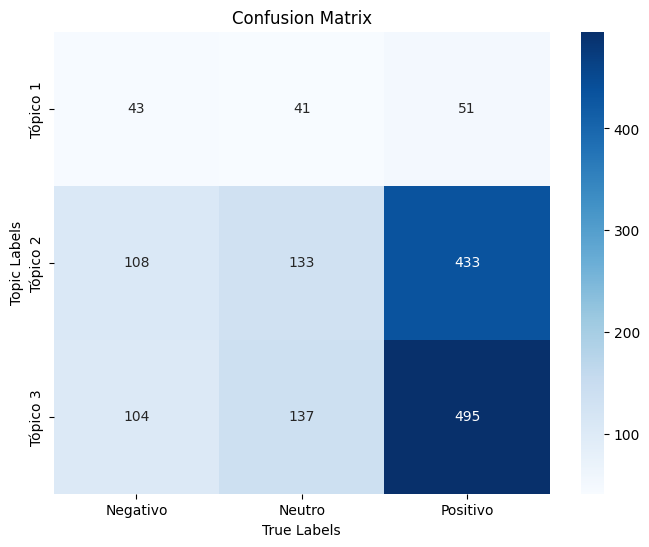

In [190]:
class_labels = ["Negativo", "Neutro", "Positivo"]
dominant_labels = ["Tópico 1", "Tópico 2", "Tópico 3"]
dominant_mapping = {0: "Negative", 1: "Positive", 2: "Neutral"}

df['Dominant_Topic'] = df['Dominant_Topic'].map(dominant_mapping)

cm_nmf = confusion_matrix(df['Target'], df['Dominant_Topic'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nmf, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=dominant_labels)
plt.xlabel('True Labels')
plt.ylabel('Topic Labels')
plt.title('Confusion Matrix')
plt.show()

In [192]:
from gensim.corpora import Dictionary

dictionary = Dictionary(df["tokens"])

corpus = [dictionary.doc2bow(doc) for doc in df["tokens"]]


from gensim.models import LdaModel

num_topics = 3
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=5):
    print(f"Tópico {idx+1}: {topic}")

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

lda_display = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(lda_display)

Tópico 1: 0.013*"patients" + 0.013*"cancer" + 0.011*"risk" + 0.010*"people" + 0.006*"type"
Tópico 2: 0.006*"new" + 0.006*"research" + 0.006*"science" + 0.005*"rampd" + 0.005*"clinical"
Tópico 3: 0.011*"patients" + 0.010*"disease" + 0.009*"people" + 0.007*"health" + 0.007*"covid"


Conseguimos observar que os tópicos 2 e 3 são fortemente associados a tweets positivos, por outro lado as classes negativo e neutro apresentam uma correlação menor em comparação com os 3 tópicos. Também é observável que o tópico 1 não apresenta nenhuma relação com nenhum das classes.

**<h1>3. Classificação de Sentimentos</h1>**

In [193]:
X = df['clean_tweet']
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.33      0.17      0.23        29
     Neutral       0.69      0.69      0.69       136
    Positive       0.68      0.74      0.71       144

    accuracy                           0.67       309
   macro avg       0.57      0.54      0.54       309
weighted avg       0.65      0.67      0.66       309

Confusion Matrix:


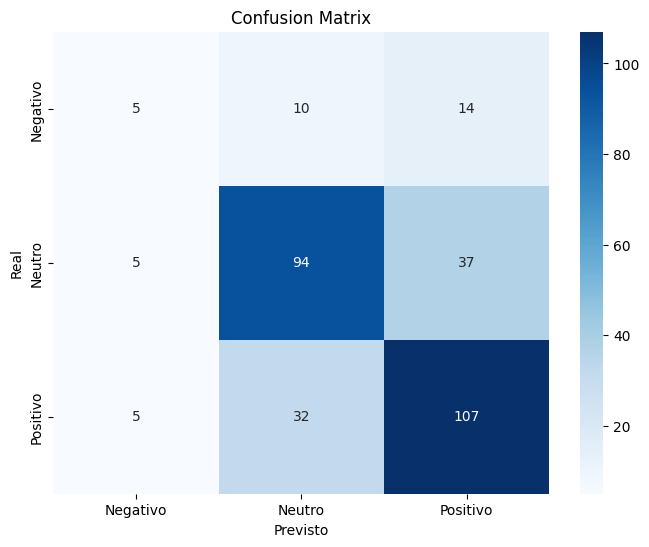

In [194]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb = MultinomialNB(class_prior=[0.33, 0.33, 0.34])
nb.fit(X_train_tfidf, y_train)

y_pred = nb.predict(X_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm_nb = confusion_matrix(y_test, y_pred)

target_names = ["Negativo", "Neutro", "Positivo"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Negative      0.444     0.276     0.340        29
     Neutral      0.689     0.750     0.718       136
    Positive      0.748     0.743     0.746       144

    accuracy                          0.702       309
   macro avg      0.627     0.590     0.601       309
weighted avg      0.694     0.702     0.696       309

Confusion Matrix:


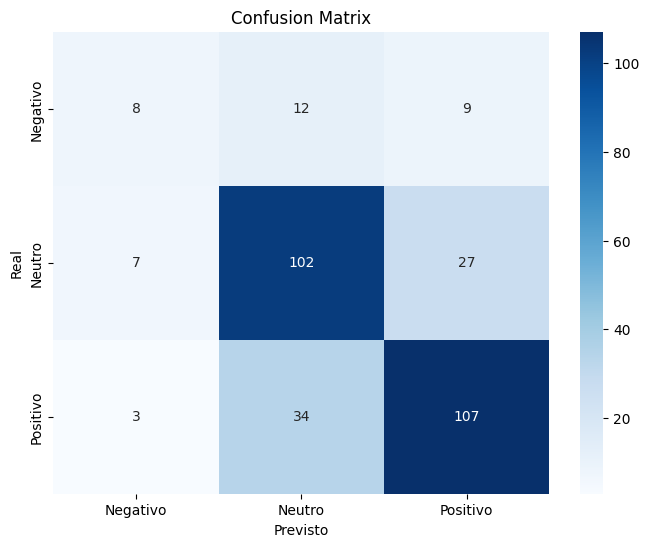

In [195]:
lr = LogisticRegression(class_weight='balanced', solver='liblinear', C=10, penalty='l2')  # Balanced class weights
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred)

target_names = ["Negativo", "Neutro", "Positivo"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()


In [196]:
print(y_test.value_counts())


Target
Positive    144
Neutral     136
Negative     29
Name: count, dtype: int64


Os modelos de **Regressão Logística** e **Naive Bayes** apresentam um desempenho geral aceitável, mas com dificuldades devido ao desbalanceamento de classes. A classe **"Negativo"**, com apenas 29 instâncias, é frequentemente mal classificada, sendo confundida com **"Neutro"** e **"Positivo"**. As classes **"Positivo"** e **"Neutro"** têm um desempenho melhor, especialmente na **Regressão Logística**. Para melhorar os resultados, seria importante equilibrar as classes, ajustando os parâmetros dos modelos ou aplicando técnicas de **oversampling** ou **undersampling**.

In [197]:
#Sentiment só tem 0 e 1, não existe neutro
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

df['sentiment'] = df['clean_tweet'].apply(get_sentiment)
df[['Target', 'sentiment']]

,Target,sentiment
0,Negative,0
1,Neutral,0
2,Neutral,1
3,Neutral,0
4,Positive,0
...,...,...
1540,Neutral,1
1541,Neutral,1
1542,Positive,0
1543,Negative,0


In [198]:
df_2targets = df[df['Target'] != 'Neutral']

C:\Users\tiago\AppData\Local\Temp\ipykernel_11360\366975504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2targets['sentiment'] = df_2targets['sentiment'].map(dominant_mapping)


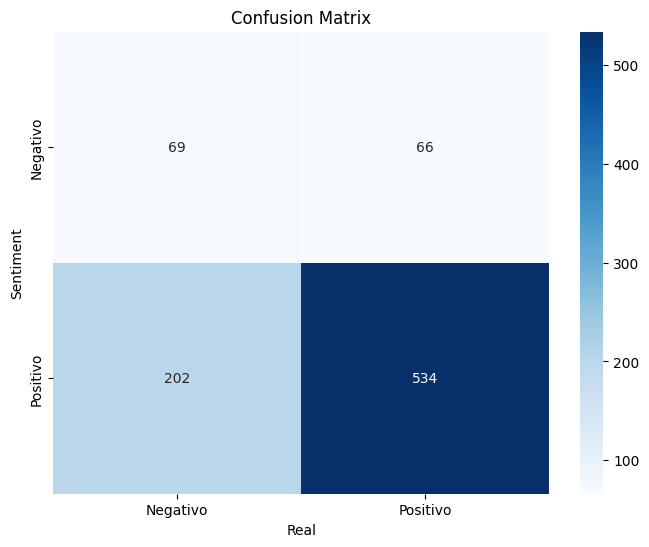

In [199]:
sentiment_mapping = {0: "Negative", 1: "Positive"}

df_2targets['sentiment'] = df_2targets['sentiment'].map(dominant_mapping)

cm_sentiment = confusion_matrix(df_2targets['Target'], df_2targets['sentiment'])
class_labels = ["Negativo", "Positivo"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Real')
plt.ylabel('Sentiment')
plt.title('Confusion Matrix')
plt.show()

A matriz de confusão mostra que o modelo de análise de sentimentos classifica corretamente a maioria dos tweets como "Positivo", mas há uma tendência de confundir as duas classes. A classe "Negativo" é frequentemente classificada como "Positivo", com 202 instâncias de "Negativo" mal classificadas, enquanto a classe "Positivo" também é confundida, com 66 instâncias incorretas.

Isso pode ser explicado pela natureza subjetiva e contextualmente variável de sentimentos em alguns tweets. Para além disso este modelo de classificação apenas classifica como "Negativo" ou "Positivo" enquanto o *dataset* trabalhado apresenta uma terceira classe "Neutro".

**<h1>4. Análises e Conclusões</h1>**

Em suma, os modelos de **Regressão Logística** e **Naive Bayes** apresentam um desempenho geral aceitável, mas são prejudicados pelo **desbalanceamento de classes**, especialmente a classe **"Negativo"**, que é frequentemente mal classificada. As classes **"Positivo"** e **"Neutro"** têm um desempenho melhor, sendo necessário considerar o equilíbrio das classes através de técnicas como **oversampling** ou **undersampling** para otimizar os resultados.

Além disso, os **tópicos 2 e 3** estão fortemente associados a **tweets positivos**, enquanto a correlação das classes **"Negativo"** e **"Neutro"** com os tópicos é mais fraca. O **tópico 1** não apresenta qualquer associação significativa com as classes.

A **análise de sentimentos** revela que, apesar de classificar corretamente a maioria dos tweets como **"Positivo"**, há uma tendência para a classe **"Negativo"** ser classificada como **"Positivo"**, o que pode ser atribuído à natureza subjetiva e variável dos sentimentos nos tweets. Para além disso, o modelo não contempla a classe **"Neutro"**, que está presente no dataset, limitando a precisão da classificação.

Trabalho realizado por: 
    Guilherme Correia, DSA, 120088
    Tiago Vaz, TDIA, 120050
    Vasco Silva, TDIA, 120055